## Stock Market Prediction And Forecasting Using Stacked LSTM
###### Name- `BHASKAR LAKHPATI` Batch- August 2022 ##

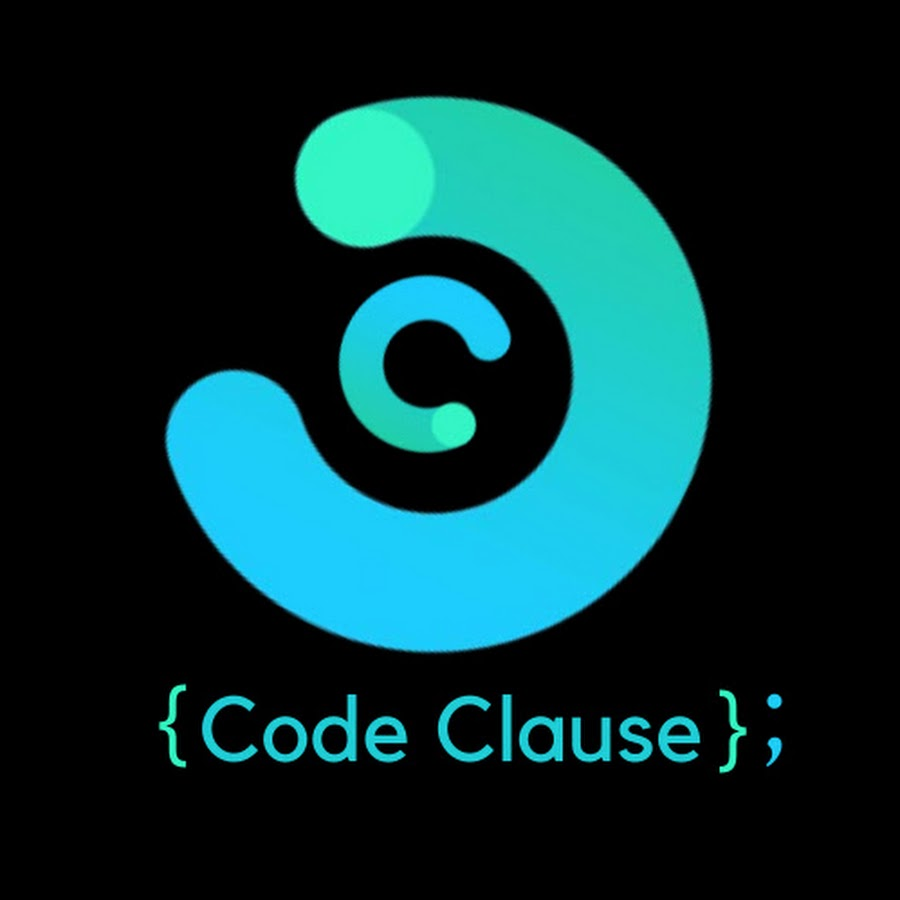

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [39]:
import os
for dirname, _, filenames in os.walk('kaggle kernels output swarnimpratapsingh/stacked-lstm -p /path/to/dest'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [40]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Data Collection
import pandas_datareader as pdr

In [42]:
key = '0d4582247cfb939072a8b196775ad482dbe00d06' # your tiingo api key
df = pdr.get_data_tiingo('AAPL', api_key = key)

In [43]:
df.to_csv('AAPL.csv')

In [44]:
df.head()

close    high       low    open    volume  \
symbol date                                                                    
AAPL   2017-08-21 00:00:00+00:00  157.21  157.89  155.1101  157.50  26145653   
       2017-08-22 00:00:00+00:00  159.78  160.00  158.0200  158.23  21297812   
       2017-08-23 00:00:00+00:00  159.98  160.47  158.8800  159.07  19198189   
       2017-08-24 00:00:00+00:00  159.27  160.74  158.5500  160.43  19029621   
       2017-08-25 00:00:00+00:00  159.86  160.56  159.2700  159.65  25015218   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2017-08-21 00:00:00+00:00  37.298598  37.459930  36.800390  37.367402   
       2017-08-22 00:00:00+00:00  37.908339  37.960535  37.490773  37.540596   
       2017-08-23 00:00:00+00:00  37.955790  38.072044  37.694811  37.739889   
       2017-08-24 00:00:00+00:00  37.787340  38.136102  37.616518  38.062554   
       2017-08-25 00:00:00+00:00  37.927319  38.093397  37.787340  37.877496   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2017-08-21 00:00:00+00:00  104582612      0.0          1.0  
       2017-08-22 00:00:00+00:00   85191248      0.0          1.0  
       2017-08-23 00:00:00+00:00   76792756      0.0          1.0  
       2017-08-24 00:00:00+00:00   76118484      0.0          1.0  
       2017-08-25 00:00:00+00:00  100060872      0.0          1.0

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1259 entries, ('AAPL', Timestamp('2017-08-21 00:00:00+0000', tz='UTC')) to ('AAPL', Timestamp('2022-08-19 00:00:00+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        1259 non-null   float64
 1   high         1259 non-null   float64
 2   low          1259 non-null   float64
 3   open         1259 non-null   float64
 4   volume       1259 non-null   int64  
 5   adjClose     1259 non-null   float64
 6   adjHigh      1259 non-null   float64
 7   adjLow       1259 non-null   float64
 8   adjOpen      1259 non-null   float64
 9   adjVolume    1259 non-null   int64  
 10  divCash      1259 non-null   float64
 11  splitFactor  1259 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 164.1+ KB


In [46]:
df1 = df.reset_index()['close']
df1.shape

(1259,)

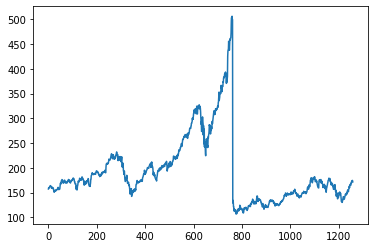

In [47]:
import matplotlib.pyplot as plt

plt.plot(df1)

### LSTM  are sensitive to the scale of the data. So we apply MinMax scaler(converting the dataset in the range of -1 to 1)

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [49]:
df1.shape

(1259, 1)

In [50]:
# splitting dataset into train-test split

# since we were having data in ascending order of time so we have to split in accordance of ascending order of time
# i.e. we will train the data while lefting last 30 days of data and test with the last 30 days data to see accuracy

training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size

train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [51]:
print(train_data.shape)
print(test_data.shape)

(818, 1)
(441, 1)


In [52]:
# converting an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [53]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [54]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(717, 100) (717,)
(340, 100) (340,)


In [55]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [56]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [58]:
import tensorflow as tf

In [59]:
# Create the Stacked LSTM model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [60]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True)) # return_sequences cares about output at every time step
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 322ms/step - loss: 0.0473 - val_loss: 0.0027
Epoch 2/100
12/12 [==============================] - 3s 285ms/step - loss: 0.0168 - val_loss: 0.0079
Epoch 3/100
12/12 [==============================] - 3s 232ms/step - loss: 0.0123 - val_loss: 0.0013
Epoch 4/100
12/12 [==============================] - 3s 214ms/step - loss: 0.0104 - val_loss: 6.9585e-04
Epoch 5/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0087 - val_loss: 3.1395e-04
Epoch 6/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0080 - val_loss: 2.6441e-04
Epoch 7/100
12/12 [==============================] - 3s 269ms/step - loss: 0.0076 - val_loss: 2.4537e-04
Epoch 8/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0073 - val_loss: 6.5903e-04
Epoch 9/100
12/12 [==============================] - 3s 237ms/step - loss: 0.0064 - val_loss: 5.6207e-04
Epoch 10/100
12/12 [==============================] - 3s 222ms/step

In [63]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 32ms/step


In [64]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [65]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

print("RMSE: ", math.sqrt(mean_squared_error(y_train, train_predict)))

RMSE:  244.184948089289


In [66]:
# Test Data RMSE
print("RMSE: ", math.sqrt(mean_squared_error(y_test, test_predict)))

RMSE:  154.88378920332946


Plotting

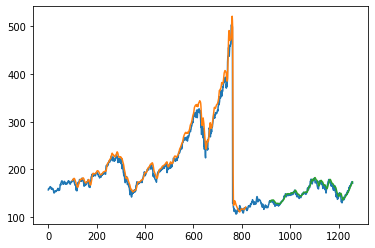

In [67]:
# shift train predictions for plotting
look_back=1000
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [68]:
len(test_data)

441

In [69]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [70]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)

[0.18063869755792106, 0.1776581089542893, 0.16974326862867878, 0.16899185973700687, 0.1793362554790231, 0.17087038196618654, 0.16278021289918598, 0.1635566687539135, 0.158422041327489, 0.14755165936130238, 0.1523356293049467, 0.15919849718221663, 0.14639949906073885, 0.1458484658735128, 0.15168440826549778, 0.15125860989355033, 0.14922980588603624, 0.13763306199123349, 0.140363180964308, 0.1251346274264245, 0.12455854727614268, 0.14226675015654344, 0.12726361928616153, 0.12804007514088916, 0.13184721352536, 0.14822792736380713, 0.12505948653725735, 0.12633688165309953, 0.11326236693800873, 0.11939887288666245, 0.09933625547902314, 0.08946775203506574, 0.10086412022542268, 0.09693174702567309, 0.10619912335629306, 0.08510958046336875, 0.0764182842830306, 0.07701941139636814, 0.09084533500313086, 0.08395742016280527, 0.0843581715716969, 0.09252348152786471, 0.10720100187852216, 0.10519724483406384, 0.10487163431433938, 0.11113337507827176, 0.09653099561678141, 0.09843456480901686, 0.1048

In [71]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.172687]
101
1 day input [0.17765811 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021
 0.16355667 0.15842204 0.14755166 0.15233563 0.1591985  0.1463995
 0.14584847 0.15168441 0.15125861 0.14922981 0.13763306 0.14036318
 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008 0.13184721
 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887 0.09933626
 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958 0.07641828
 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348 0.107201
 0.10519724 0.10487163 0.11113338 0.096531   0.09843456 0.10487163
 0.10299311 0.08966813 0.07586725 0.0627176  0.06492173 0.07160927
 0.05815905 0.06191609 0.07271133 0.07140889 0.0787226  0.08721353
 0.08721353 0.07664371 0.08112711 0.07484033 0.0803757  0.08696306
 0.09036944 0.09896055 0.10068879 0.0952536  0.09773325 0.09680651
 0.10427051 0.10852849 0.10076393 0.11060739 0.11571697 0.12150282
 0.1183469  0.11549155 0.11211021 0.12510958 0.12651221 0.13943644
 0.13693175 0.1331747  0.14850344 0.14

9 day output [[0.19199646]]
10 day input [0.15233563 0.1591985  0.1463995  0.14584847 0.15168441 0.15125861
 0.14922981 0.13763306 0.14036318 0.12513463 0.12455855 0.14226675
 0.12726362 0.12804008 0.13184721 0.14822793 0.12505949 0.12633688
 0.11326237 0.11939887 0.09933626 0.08946775 0.10086412 0.09693175
 0.10619912 0.08510958 0.07641828 0.07701941 0.09084534 0.08395742
 0.08435817 0.09252348 0.107201   0.10519724 0.10487163 0.11113338
 0.096531   0.09843456 0.10487163 0.10299311 0.08966813 0.07586725
 0.0627176  0.06492173 0.07160927 0.05815905 0.06191609 0.07271133
 0.07140889 0.0787226  0.08721353 0.08721353 0.07664371 0.08112711
 0.07484033 0.0803757  0.08696306 0.09036944 0.09896055 0.10068879
 0.0952536  0.09773325 0.09680651 0.10427051 0.10852849 0.10076393
 0.11060739 0.11571697 0.12150282 0.1183469  0.11549155 0.11211021
 0.12510958 0.12651221 0.13943644 0.13693175 0.1331747  0.14850344
 0.14770194 0.14654978 0.14534753 0.14547276 0.15629305 0.15441453
 0.16345648 0.1661866

17 day output [[0.21393812]]
18 day input [0.14036318 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008
 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887
 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958
 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348
 0.107201   0.10519724 0.10487163 0.11113338 0.096531   0.09843456
 0.10487163 0.10299311 0.08966813 0.07586725 0.0627176  0.06492173
 0.07160927 0.05815905 0.06191609 0.07271133 0.07140889 0.0787226
 0.08721353 0.08721353 0.07664371 0.08112711 0.07484033 0.0803757
 0.08696306 0.09036944 0.09896055 0.10068879 0.0952536  0.09773325
 0.09680651 0.10427051 0.10852849 0.10076393 0.11060739 0.11571697
 0.12150282 0.1183469  0.11549155 0.11211021 0.12510958 0.12651221
 0.13943644 0.13693175 0.1331747  0.14850344 0.14770194 0.14654978
 0.14534753 0.14547276 0.15629305 0.15441453 0.16345648 0.1661866
 0.16578585 0.16959299 0.16859111 0.16200376 0.17268699 0.17423853
 0.1759911  0.17795925 

25 day output [[0.23974472]]
26 day input [0.12505949 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775
 0.10086412 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941
 0.09084534 0.08395742 0.08435817 0.09252348 0.107201   0.10519724
 0.10487163 0.11113338 0.096531   0.09843456 0.10487163 0.10299311
 0.08966813 0.07586725 0.0627176  0.06492173 0.07160927 0.05815905
 0.06191609 0.07271133 0.07140889 0.0787226  0.08721353 0.08721353
 0.07664371 0.08112711 0.07484033 0.0803757  0.08696306 0.09036944
 0.09896055 0.10068879 0.0952536  0.09773325 0.09680651 0.10427051
 0.10852849 0.10076393 0.11060739 0.11571697 0.12150282 0.1183469
 0.11549155 0.11211021 0.12510958 0.12651221 0.13943644 0.13693175
 0.1331747  0.14850344 0.14770194 0.14654978 0.14534753 0.14547276
 0.15629305 0.15441453 0.16345648 0.1661866  0.16578585 0.16959299
 0.16859111 0.16200376 0.17268699 0.17423853 0.1759911  0.17795925
 0.18008938 0.18233177 0.18465561 0.1870451  0.18949306 0.19199646
 0.1945539  0.1971644

In [80]:
day_new=np.arange(1,101)
day_pred=np.arange(101,120)

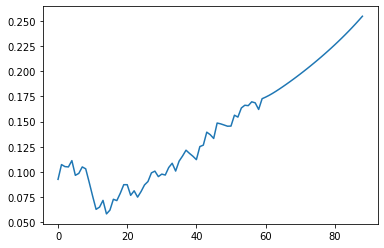

In [87]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)